In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [72]:
## import helper functions

import sys
sys.path.append("../")
from src.clean_churn_data import clean_churn_data
from src.roc import plot_roc_curve
from src.confusion_df import confusion_df
from src.confusion_df import render_mpl_table
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
## import sklearn modules

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# import tensorflow modules. tensorflow was run on a docker container

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# load and clean data

churn = pd.read_csv('../data/churn_train.csv')
churn = clean_churn_data(churn)
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Data columns (total 13 columns):
avg_dist                  39681 non-null float64
avg_rating_by_driver      39681 non-null float64
avg_rating_of_driver      39681 non-null float64
avg_surge                 39681 non-null float64
phone                     39681 non-null int64
surge_pct                 39681 non-null float64
trips_in_first_30_days    39681 non-null int64
luxury_car_user           39681 non-null int64
weekday_pct               39681 non-null float64
city: Astapor             39681 non-null int64
city: King's Landing      39681 non-null int64
city: Winterfell          39681 non-null int64
churn?                    39681 non-null int64
dtypes: float64(6), int64(7)
memory usage: 4.2 MB


In [38]:
# feature engineering

cols = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']

for col in cols:
    churn[(col + ' x^2')] = churn[col] ** 2
    churn[(col + ' x^3')] = churn[col] ** 3
    churn[(col + ' exp^x')] = np.exp(churn[col])
    churn[(col + ' log')] = np.log(churn[col] + 10**-10)
    churn[(col + ' sin')] = np.sin(churn[col])
    churn[(col + ' cos')] = np.cos(churn[col])
    churn[(col + ' 1/x')] = 1 / (churn[col] + 10**-10)
    
    for col2 in cols:
        churn[(col + ' * ' + col2)] = churn[col] * churn[col2]

In [42]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Columns: 111 entries, avg_dist to weekday_pct log
dtypes: float64(101), int64(10)
memory usage: 33.9 MB


In [43]:
# create model data

X = churn.drop(columns=['churn?']).values
y = churn['churn?'].values
X[X > 10**10] = 10**10   # reset inf values

In [44]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29760, 110) (9921, 110) (29760,) (9921,)


In [45]:
# standardize data

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train)

In [46]:
# create and compile neural network

n_samples, n_feats = X_train.shape

model = Sequential()

hidden_units = n_feats
n_classes = 1
epochs = 1000
sgd_lr = 0.01

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='relu')

hidden_layer2 = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='tanh')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(hidden_layer)
model.add(hidden_layer2)
model.add(output_layer)
model.add(Dropout(rate=0.5))

opt = SGD(lr=sgd_lr)
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=["accuracy", Precision(), Recall()] )

history = model.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=5000, 
          verbose=2, 
          validation_split=0.2)

Train on 23808 samples, validate on 5952 samples
Epoch 1/1000
23808/23808 - 1s - loss: 5.6054 - accuracy: 0.3986 - precision: 0.6155 - recall: 0.1039 - val_loss: 1.5523 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
23808/23808 - 0s - loss: 5.3897 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5319 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
23808/23808 - 0s - loss: 5.4089 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5124 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
23808/23808 - 0s - loss: 5.3398 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4933 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
23808/23808 - 0s - loss: 5.4254 - accuracy: 0.3742 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4755 - val_accuracy:

Epoch 41/1000
23808/23808 - 0s - loss: 5.2273 - accuracy: 0.3758 - precision: 0.8364 - recall: 0.0031 - val_loss: 1.0634 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 42/1000
23808/23808 - 0s - loss: 5.1875 - accuracy: 0.3770 - precision: 0.8602 - recall: 0.0054 - val_loss: 1.0560 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 43/1000
23808/23808 - 0s - loss: 5.1464 - accuracy: 0.3790 - precision: 0.8662 - recall: 0.0091 - val_loss: 1.0487 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 44/1000
23808/23808 - 0s - loss: 5.2221 - accuracy: 0.3807 - precision: 0.8598 - recall: 0.0123 - val_loss: 1.0417 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 45/1000
23808/23808 - 0s - loss: 5.1643 - accuracy: 0.3824 - precision: 0.8392 - recall: 0.0161 - val_loss: 1.0347 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 46/1000
2

23808/23808 - 0s - loss: 5.1606 - accuracy: 0.5118 - precision: 0.6440 - recall: 0.4919 - val_loss: 0.8737 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 84/1000
23808/23808 - 0s - loss: 5.1063 - accuracy: 0.5113 - precision: 0.6411 - recall: 0.4978 - val_loss: 0.8714 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 85/1000
23808/23808 - 0s - loss: 5.1063 - accuracy: 0.5102 - precision: 0.6400 - recall: 0.4970 - val_loss: 0.8696 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 86/1000
23808/23808 - 0s - loss: 5.1487 - accuracy: 0.5110 - precision: 0.6424 - recall: 0.4931 - val_loss: 0.8672 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 87/1000
23808/23808 - 0s - loss: 5.0933 - accuracy: 0.5136 - precision: 0.6439 - recall: 0.4982 - val_loss: 0.8650 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 88/1000
23808/23808 - 0s - loss: 5.0870 - a

Epoch 126/1000
23808/23808 - 0s - loss: 5.1716 - accuracy: 0.5169 - precision: 0.6553 - recall: 0.4811 - val_loss: 0.8149 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 127/1000
23808/23808 - 0s - loss: 5.1629 - accuracy: 0.5218 - precision: 0.6617 - recall: 0.4824 - val_loss: 0.8141 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 128/1000
23808/23808 - 1s - loss: 5.1144 - accuracy: 0.5250 - precision: 0.6646 - recall: 0.4864 - val_loss: 0.8132 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 129/1000
23808/23808 - 1s - loss: 5.1208 - accuracy: 0.5248 - precision: 0.6643 - recall: 0.4865 - val_loss: 0.8121 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 130/1000
23808/23808 - 1s - loss: 5.0879 - accuracy: 0.5224 - precision: 0.6606 - recall: 0.4871 - val_loss: 0.8114 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 131/1000
23808/23808 - 0

Epoch 169/1000
23808/23808 - 0s - loss: 5.1517 - accuracy: 0.5328 - precision: 0.6856 - recall: 0.4683 - val_loss: 0.7860 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 170/1000
23808/23808 - 1s - loss: 5.1133 - accuracy: 0.5388 - precision: 0.6930 - recall: 0.4720 - val_loss: 0.7853 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 171/1000
23808/23808 - 0s - loss: 5.0849 - accuracy: 0.5377 - precision: 0.6898 - recall: 0.4747 - val_loss: 0.7849 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 172/1000
23808/23808 - 0s - loss: 5.1006 - accuracy: 0.5337 - precision: 0.6852 - recall: 0.4714 - val_loss: 0.7844 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 173/1000
23808/23808 - 0s - loss: 5.0851 - accuracy: 0.5397 - precision: 0.6927 - recall: 0.4752 - val_loss: 0.7838 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 174/1000
23808/23808 - 0

Epoch 212/1000
23808/23808 - 0s - loss: 5.0838 - accuracy: 0.5498 - precision: 0.7197 - recall: 0.4596 - val_loss: 0.7652 - val_accuracy: 0.3735 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 213/1000
23808/23808 - 1s - loss: 5.0333 - accuracy: 0.5546 - precision: 0.7234 - recall: 0.4666 - val_loss: 0.7646 - val_accuracy: 0.3735 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 214/1000
23808/23808 - 1s - loss: 5.1132 - accuracy: 0.5497 - precision: 0.7217 - recall: 0.4565 - val_loss: 0.7645 - val_accuracy: 0.3733 - val_precision: 1.0000 - val_recall: 0.0035
Epoch 215/1000
23808/23808 - 1s - loss: 5.0534 - accuracy: 0.5536 - precision: 0.7239 - recall: 0.4633 - val_loss: 0.7643 - val_accuracy: 0.3733 - val_precision: 1.0000 - val_recall: 0.0035
Epoch 216/1000
23808/23808 - 1s - loss: 5.0963 - accuracy: 0.5514 - precision: 0.7238 - recall: 0.4579 - val_loss: 0.7639 - val_accuracy: 0.3733 - val_precision: 1.0000 - val_recall: 0.0035
Epoch 217/1000
23808/23808 - 1s - loss: 5.1118 - a

Epoch 256/1000
23808/23808 - 0s - loss: 5.1583 - accuracy: 0.5572 - precision: 0.7482 - recall: 0.4407 - val_loss: 0.7614 - val_accuracy: 0.3804 - val_precision: 0.9825 - val_recall: 0.0150
Epoch 257/1000
23808/23808 - 0s - loss: 5.1095 - accuracy: 0.5614 - precision: 0.7520 - recall: 0.4463 - val_loss: 0.7609 - val_accuracy: 0.3810 - val_precision: 0.9836 - val_recall: 0.0160
Epoch 258/1000
23808/23808 - 0s - loss: 5.0968 - accuracy: 0.5627 - precision: 0.7534 - recall: 0.4477 - val_loss: 0.7597 - val_accuracy: 0.3819 - val_precision: 0.9848 - val_recall: 0.0174
Epoch 259/1000
23808/23808 - 0s - loss: 5.1088 - accuracy: 0.5638 - precision: 0.7572 - recall: 0.4461 - val_loss: 0.7608 - val_accuracy: 0.3816 - val_precision: 0.9844 - val_recall: 0.0168
Epoch 260/1000
23808/23808 - 0s - loss: 5.0184 - accuracy: 0.5648 - precision: 0.7526 - recall: 0.4538 - val_loss: 0.7603 - val_accuracy: 0.3822 - val_precision: 0.9853 - val_recall: 0.0179
Epoch 261/1000
23808/23808 - 0s - loss: 5.1024 - a

Epoch 300/1000
23808/23808 - 1s - loss: 5.1240 - accuracy: 0.5634 - precision: 0.7641 - recall: 0.4373 - val_loss: 0.7601 - val_accuracy: 0.3913 - val_precision: 0.9839 - val_recall: 0.0326
Epoch 301/1000
23808/23808 - 1s - loss: 5.0792 - accuracy: 0.5661 - precision: 0.7681 - recall: 0.4392 - val_loss: 0.7609 - val_accuracy: 0.3901 - val_precision: 0.9829 - val_recall: 0.0307
Epoch 302/1000
23808/23808 - 1s - loss: 5.1573 - accuracy: 0.5632 - precision: 0.7654 - recall: 0.4355 - val_loss: 0.7616 - val_accuracy: 0.3894 - val_precision: 0.9823 - val_recall: 0.0297
Epoch 303/1000
23808/23808 - 1s - loss: 5.0529 - accuracy: 0.5668 - precision: 0.7699 - recall: 0.4390 - val_loss: 0.7607 - val_accuracy: 0.3920 - val_precision: 0.9844 - val_recall: 0.0337
Epoch 304/1000
23808/23808 - 1s - loss: 5.0717 - accuracy: 0.5670 - precision: 0.7678 - recall: 0.4416 - val_loss: 0.7605 - val_accuracy: 0.3920 - val_precision: 0.9844 - val_recall: 0.0337
Epoch 305/1000
23808/23808 - 1s - loss: 5.0681 - a

Epoch 344/1000
23808/23808 - 0s - loss: 5.0274 - accuracy: 0.5732 - precision: 0.7892 - recall: 0.4339 - val_loss: 0.7728 - val_accuracy: 0.3874 - val_precision: 0.9802 - val_recall: 0.0264
Epoch 345/1000
23808/23808 - 0s - loss: 5.1439 - accuracy: 0.5662 - precision: 0.7816 - recall: 0.4257 - val_loss: 0.7727 - val_accuracy: 0.3844 - val_precision: 0.9759 - val_recall: 0.0216
Epoch 346/1000
23808/23808 - 0s - loss: 5.0613 - accuracy: 0.5699 - precision: 0.7832 - recall: 0.4323 - val_loss: 0.7694 - val_accuracy: 0.3879 - val_precision: 0.9808 - val_recall: 0.0273
Epoch 347/1000
23808/23808 - 1s - loss: 5.0601 - accuracy: 0.5677 - precision: 0.7803 - recall: 0.4303 - val_loss: 0.7666 - val_accuracy: 0.3901 - val_precision: 0.9829 - val_recall: 0.0307
Epoch 348/1000
23808/23808 - 0s - loss: 5.1384 - accuracy: 0.5652 - precision: 0.7784 - recall: 0.4266 - val_loss: 0.7649 - val_accuracy: 0.3916 - val_precision: 0.9841 - val_recall: 0.0331
Epoch 349/1000
23808/23808 - 0s - loss: 5.0328 - a

Epoch 386/1000
23808/23808 - 0s - loss: 5.2159 - accuracy: 0.3913 - precision: 0.7491 - recall: 0.0411 - val_loss: 1.1452 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 387/1000
23808/23808 - 0s - loss: 5.2558 - accuracy: 0.3926 - precision: 0.7526 - recall: 0.0439 - val_loss: 1.1358 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 388/1000
23808/23808 - 0s - loss: 5.3009 - accuracy: 0.3936 - precision: 0.7287 - recall: 0.0494 - val_loss: 1.1270 - val_accuracy: 0.3711 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 389/1000
23808/23808 - 0s - loss: 5.2543 - accuracy: 0.3947 - precision: 0.7197 - recall: 0.0538 - val_loss: 1.1192 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 390/1000
23808/23808 - 0s - loss: 5.1704 - accuracy: 0.3952 - precision: 0.6972 - recall: 0.0593 - val_loss: 1.1111 - val_accuracy: 0.3716 - val_precision: 1.0000 - val_recall: 8.0150e-04
Epoch 391/1000
238

Epoch 429/1000
23808/23808 - 0s - loss: 5.1665 - accuracy: 0.4501 - precision: 0.7314 - recall: 0.1918 - val_loss: 0.9557 - val_accuracy: 0.3723 - val_precision: 1.0000 - val_recall: 0.0019
Epoch 430/1000
23808/23808 - 0s - loss: 5.1668 - accuracy: 0.4526 - precision: 0.7282 - recall: 0.1999 - val_loss: 0.9525 - val_accuracy: 0.3723 - val_precision: 1.0000 - val_recall: 0.0019
Epoch 431/1000
23808/23808 - 0s - loss: 5.1080 - accuracy: 0.4543 - precision: 0.7254 - recall: 0.2061 - val_loss: 0.9496 - val_accuracy: 0.3723 - val_precision: 1.0000 - val_recall: 0.0019
Epoch 432/1000
23808/23808 - 0s - loss: 5.1589 - accuracy: 0.4575 - precision: 0.7311 - recall: 0.2106 - val_loss: 0.9470 - val_accuracy: 0.3721 - val_precision: 1.0000 - val_recall: 0.0016
Epoch 433/1000
23808/23808 - 1s - loss: 5.1913 - accuracy: 0.4609 - precision: 0.7325 - recall: 0.2181 - val_loss: 0.9441 - val_accuracy: 0.3721 - val_precision: 1.0000 - val_recall: 0.0016
Epoch 434/1000
23808/23808 - 1s - loss: 5.1583 - a

Epoch 472/1000
23808/23808 - 0s - loss: 5.1599 - accuracy: 0.5442 - precision: 0.7256 - recall: 0.4369 - val_loss: 0.8514 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 473/1000
23808/23808 - 0s - loss: 5.0953 - accuracy: 0.5467 - precision: 0.7238 - recall: 0.4457 - val_loss: 0.8490 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 474/1000
23808/23808 - 1s - loss: 5.1415 - accuracy: 0.5460 - precision: 0.7263 - recall: 0.4404 - val_loss: 0.8467 - val_accuracy: 0.3713 - val_precision: 1.0000 - val_recall: 2.6717e-04
Epoch 475/1000
23808/23808 - 0s - loss: 5.0926 - accuracy: 0.5472 - precision: 0.7226 - recall: 0.4486 - val_loss: 0.8443 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 476/1000
23808/23808 - 0s - loss: 5.0842 - accuracy: 0.5478 - precision: 0.7222 - recall: 0.4509 - val_loss: 0.8420 - val_accuracy: 0.3715 - val_precision: 1.0000 - val_recall: 5.3433e-04
Epoch 477/1000
23808/23808 - 0

Epoch 515/1000
23808/23808 - 0s - loss: 5.1347 - accuracy: 0.5528 - precision: 0.7362 - recall: 0.4447 - val_loss: 0.7946 - val_accuracy: 0.3737 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 516/1000
23808/23808 - 0s - loss: 5.0502 - accuracy: 0.5601 - precision: 0.7461 - recall: 0.4502 - val_loss: 0.7933 - val_accuracy: 0.3737 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 517/1000
23808/23808 - 0s - loss: 5.1412 - accuracy: 0.5517 - precision: 0.7365 - recall: 0.4417 - val_loss: 0.7931 - val_accuracy: 0.3735 - val_precision: 1.0000 - val_recall: 0.0037
Epoch 518/1000
23808/23808 - 0s - loss: 5.1211 - accuracy: 0.5507 - precision: 0.7346 - recall: 0.4415 - val_loss: 0.7924 - val_accuracy: 0.3737 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 519/1000
23808/23808 - 0s - loss: 5.0756 - accuracy: 0.5549 - precision: 0.7398 - recall: 0.4453 - val_loss: 0.7913 - val_accuracy: 0.3737 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 520/1000
23808/23808 - 0s - loss: 5.1145 - a

Epoch 559/1000
23808/23808 - 0s - loss: 5.0757 - accuracy: 0.5608 - precision: 0.7580 - recall: 0.4380 - val_loss: 0.7722 - val_accuracy: 0.3777 - val_precision: 1.0000 - val_recall: 0.0104
Epoch 560/1000
23808/23808 - 0s - loss: 5.0403 - accuracy: 0.5626 - precision: 0.7589 - recall: 0.4412 - val_loss: 0.7717 - val_accuracy: 0.3777 - val_precision: 1.0000 - val_recall: 0.0104
Epoch 561/1000
23808/23808 - 0s - loss: 5.0710 - accuracy: 0.5612 - precision: 0.7596 - recall: 0.4373 - val_loss: 0.7711 - val_accuracy: 0.3779 - val_precision: 1.0000 - val_recall: 0.0107
Epoch 562/1000
23808/23808 - 0s - loss: 5.0678 - accuracy: 0.5628 - precision: 0.7642 - recall: 0.4358 - val_loss: 0.7702 - val_accuracy: 0.3785 - val_precision: 1.0000 - val_recall: 0.0118
Epoch 563/1000
23808/23808 - 0s - loss: 5.0371 - accuracy: 0.5616 - precision: 0.7589 - recall: 0.4390 - val_loss: 0.7696 - val_accuracy: 0.3787 - val_precision: 1.0000 - val_recall: 0.0120
Epoch 564/1000
23808/23808 - 0s - loss: 5.1331 - a

Epoch 603/1000
23808/23808 - 0s - loss: 5.0745 - accuracy: 0.5647 - precision: 0.7736 - recall: 0.4304 - val_loss: 0.7644 - val_accuracy: 0.3854 - val_precision: 1.0000 - val_recall: 0.0227
Epoch 604/1000
23808/23808 - 0s - loss: 5.1408 - accuracy: 0.5625 - precision: 0.7745 - recall: 0.4246 - val_loss: 0.7641 - val_accuracy: 0.3864 - val_precision: 1.0000 - val_recall: 0.0243
Epoch 605/1000
23808/23808 - 0s - loss: 5.0138 - accuracy: 0.5683 - precision: 0.7763 - recall: 0.4356 - val_loss: 0.7626 - val_accuracy: 0.3881 - val_precision: 1.0000 - val_recall: 0.0270
Epoch 606/1000
23808/23808 - 0s - loss: 5.1092 - accuracy: 0.5595 - precision: 0.7652 - recall: 0.4272 - val_loss: 0.7646 - val_accuracy: 0.3854 - val_precision: 1.0000 - val_recall: 0.0227
Epoch 607/1000
23808/23808 - 0s - loss: 5.0935 - accuracy: 0.5664 - precision: 0.7768 - recall: 0.4309 - val_loss: 0.7644 - val_accuracy: 0.3858 - val_precision: 1.0000 - val_recall: 0.0232
Epoch 608/1000
23808/23808 - 0s - loss: 5.1286 - a

Epoch 647/1000
23808/23808 - 0s - loss: 5.0632 - accuracy: 0.5667 - precision: 0.7824 - recall: 0.4261 - val_loss: 0.7623 - val_accuracy: 0.3940 - val_precision: 0.9928 - val_recall: 0.0366
Epoch 648/1000
23808/23808 - 0s - loss: 5.0356 - accuracy: 0.5712 - precision: 0.7855 - recall: 0.4330 - val_loss: 0.7630 - val_accuracy: 0.3930 - val_precision: 0.9924 - val_recall: 0.0350
Epoch 649/1000
23808/23808 - 0s - loss: 5.1231 - accuracy: 0.5637 - precision: 0.7799 - recall: 0.4219 - val_loss: 0.7627 - val_accuracy: 0.3933 - val_precision: 0.9925 - val_recall: 0.0355
Epoch 650/1000
23808/23808 - 0s - loss: 5.1503 - accuracy: 0.5641 - precision: 0.7832 - recall: 0.4196 - val_loss: 0.7621 - val_accuracy: 0.3936 - val_precision: 0.9926 - val_recall: 0.0361
Epoch 651/1000
23808/23808 - 0s - loss: 5.1192 - accuracy: 0.5685 - precision: 0.7885 - recall: 0.4243 - val_loss: 0.7606 - val_accuracy: 0.3950 - val_precision: 0.9931 - val_recall: 0.0382
Epoch 652/1000
23808/23808 - 0s - loss: 5.0930 - a

Epoch 691/1000
23808/23808 - 0s - loss: 5.0464 - accuracy: 0.5701 - precision: 0.7912 - recall: 0.4254 - val_loss: 0.7679 - val_accuracy: 0.3923 - val_precision: 0.9846 - val_recall: 0.0342
Epoch 692/1000
23808/23808 - 0s - loss: 5.0812 - accuracy: 0.5672 - precision: 0.7859 - recall: 0.4240 - val_loss: 0.7655 - val_accuracy: 0.3926 - val_precision: 0.9848 - val_recall: 0.0347
Epoch 693/1000
23808/23808 - 0s - loss: 5.0116 - accuracy: 0.5722 - precision: 0.7894 - recall: 0.4314 - val_loss: 0.7623 - val_accuracy: 0.3945 - val_precision: 0.9860 - val_recall: 0.0377
Epoch 694/1000
23808/23808 - 0s - loss: 5.1110 - accuracy: 0.5680 - precision: 0.7860 - recall: 0.4257 - val_loss: 0.7604 - val_accuracy: 0.3950 - val_precision: 0.9863 - val_recall: 0.0385
Epoch 695/1000
23808/23808 - 0s - loss: 5.0503 - accuracy: 0.5722 - precision: 0.7899 - recall: 0.4310 - val_loss: 0.7632 - val_accuracy: 0.3933 - val_precision: 0.9853 - val_recall: 0.0358
Epoch 696/1000
23808/23808 - 0s - loss: 5.0359 - a

Epoch 735/1000
23808/23808 - 0s - loss: 5.1125 - accuracy: 0.5683 - precision: 0.7873 - recall: 0.4250 - val_loss: 0.7563 - val_accuracy: 0.4012 - val_precision: 0.9891 - val_recall: 0.0484
Epoch 736/1000
23808/23808 - 0s - loss: 5.0503 - accuracy: 0.5718 - precision: 0.7915 - recall: 0.4287 - val_loss: 0.7567 - val_accuracy: 0.4005 - val_precision: 0.9888 - val_recall: 0.0473
Epoch 737/1000
23808/23808 - 0s - loss: 5.0366 - accuracy: 0.5741 - precision: 0.7927 - recall: 0.4326 - val_loss: 0.7552 - val_accuracy: 0.4020 - val_precision: 0.9894 - val_recall: 0.0497
Epoch 738/1000
23808/23808 - 0s - loss: 5.1081 - accuracy: 0.5689 - precision: 0.7911 - recall: 0.4228 - val_loss: 0.7554 - val_accuracy: 0.4015 - val_precision: 0.9892 - val_recall: 0.0489
Epoch 739/1000
23808/23808 - 0s - loss: 5.0844 - accuracy: 0.5688 - precision: 0.7886 - recall: 0.4249 - val_loss: 0.7555 - val_accuracy: 0.4015 - val_precision: 0.9892 - val_recall: 0.0489
Epoch 740/1000
23808/23808 - 0s - loss: 5.0755 - a

Epoch 779/1000
23808/23808 - 0s - loss: 5.0717 - accuracy: 0.5699 - precision: 0.7894 - recall: 0.4265 - val_loss: 0.7539 - val_accuracy: 0.4037 - val_precision: 0.9899 - val_recall: 0.0524
Epoch 780/1000
23808/23808 - 0s - loss: 5.1007 - accuracy: 0.5707 - precision: 0.7945 - recall: 0.4237 - val_loss: 0.7539 - val_accuracy: 0.4041 - val_precision: 0.9900 - val_recall: 0.0529
Epoch 781/1000
23808/23808 - 0s - loss: 5.0231 - accuracy: 0.5769 - precision: 0.7983 - recall: 0.4335 - val_loss: 0.7538 - val_accuracy: 0.4041 - val_precision: 0.9900 - val_recall: 0.0529
Epoch 782/1000
23808/23808 - 0s - loss: 5.0508 - accuracy: 0.5715 - precision: 0.7907 - recall: 0.4288 - val_loss: 0.7544 - val_accuracy: 0.4039 - val_precision: 0.9899 - val_recall: 0.0526
Epoch 783/1000
23808/23808 - 1s - loss: 5.0578 - accuracy: 0.5734 - precision: 0.7977 - recall: 0.4265 - val_loss: 0.7538 - val_accuracy: 0.4039 - val_precision: 0.9899 - val_recall: 0.0526
Epoch 784/1000
23808/23808 - 1s - loss: 5.0472 - a

Epoch 823/1000
23808/23808 - 0s - loss: 5.0787 - accuracy: 0.5724 - precision: 0.7975 - recall: 0.4245 - val_loss: 0.7518 - val_accuracy: 0.4061 - val_precision: 0.9815 - val_recall: 0.0566
Epoch 824/1000
23808/23808 - 0s - loss: 5.0081 - accuracy: 0.5780 - precision: 0.8007 - recall: 0.4335 - val_loss: 0.7514 - val_accuracy: 0.4069 - val_precision: 0.9819 - val_recall: 0.0580
Epoch 825/1000
23808/23808 - 0s - loss: 5.0492 - accuracy: 0.5719 - precision: 0.7931 - recall: 0.4275 - val_loss: 0.7515 - val_accuracy: 0.4066 - val_precision: 0.9817 - val_recall: 0.0574
Epoch 826/1000
23808/23808 - 0s - loss: 5.1526 - accuracy: 0.5706 - precision: 0.7977 - recall: 0.4206 - val_loss: 0.7530 - val_accuracy: 0.4044 - val_precision: 0.9806 - val_recall: 0.0540
Epoch 827/1000
23808/23808 - 0s - loss: 5.0388 - accuracy: 0.5714 - precision: 0.7926 - recall: 0.4268 - val_loss: 0.7522 - val_accuracy: 0.4056 - val_precision: 0.9812 - val_recall: 0.0558
Epoch 828/1000
23808/23808 - 0s - loss: 5.1166 - a

Epoch 867/1000
23808/23808 - 0s - loss: 5.0403 - accuracy: 0.5762 - precision: 0.8017 - recall: 0.4289 - val_loss: 0.7498 - val_accuracy: 0.4079 - val_precision: 0.9824 - val_recall: 0.0596
Epoch 868/1000
23808/23808 - 0s - loss: 5.0240 - accuracy: 0.5751 - precision: 0.7955 - recall: 0.4322 - val_loss: 0.7505 - val_accuracy: 0.4068 - val_precision: 0.9818 - val_recall: 0.0577
Epoch 869/1000
23808/23808 - 0s - loss: 5.0568 - accuracy: 0.5733 - precision: 0.7993 - recall: 0.4249 - val_loss: 0.7492 - val_accuracy: 0.4089 - val_precision: 0.9828 - val_recall: 0.0612
Epoch 870/1000
23808/23808 - 1s - loss: 5.0276 - accuracy: 0.5725 - precision: 0.7926 - recall: 0.4292 - val_loss: 0.7492 - val_accuracy: 0.4088 - val_precision: 0.9828 - val_recall: 0.0609
Epoch 871/1000
23808/23808 - 1s - loss: 4.9941 - accuracy: 0.5797 - precision: 0.8040 - recall: 0.4343 - val_loss: 0.7497 - val_accuracy: 0.4076 - val_precision: 0.9822 - val_recall: 0.0590
Epoch 872/1000
23808/23808 - 1s - loss: 5.0824 - a

Epoch 911/1000
23808/23808 - 0s - loss: 5.0703 - accuracy: 0.5735 - precision: 0.7971 - recall: 0.4273 - val_loss: 0.7487 - val_accuracy: 0.4079 - val_precision: 0.9824 - val_recall: 0.0596
Epoch 912/1000
23808/23808 - 0s - loss: 5.0664 - accuracy: 0.5731 - precision: 0.7947 - recall: 0.4285 - val_loss: 0.7489 - val_accuracy: 0.4078 - val_precision: 0.9823 - val_recall: 0.0593
Epoch 913/1000
23808/23808 - 0s - loss: 5.0203 - accuracy: 0.5777 - precision: 0.8025 - recall: 0.4313 - val_loss: 0.7479 - val_accuracy: 0.4089 - val_precision: 0.9828 - val_recall: 0.0612
Epoch 914/1000
23808/23808 - 0s - loss: 5.0008 - accuracy: 0.5762 - precision: 0.7976 - recall: 0.4325 - val_loss: 0.7484 - val_accuracy: 0.4078 - val_precision: 0.9823 - val_recall: 0.0593
Epoch 915/1000
23808/23808 - 0s - loss: 5.1266 - accuracy: 0.5715 - precision: 0.7957 - recall: 0.4241 - val_loss: 0.7490 - val_accuracy: 0.4074 - val_precision: 0.9821 - val_recall: 0.0588
Epoch 916/1000
23808/23808 - 0s - loss: 5.0697 - a

Epoch 955/1000
23808/23808 - 0s - loss: 5.0816 - accuracy: 0.5729 - precision: 0.7963 - recall: 0.4266 - val_loss: 0.7481 - val_accuracy: 0.4078 - val_precision: 0.9823 - val_recall: 0.0593
Epoch 956/1000
23808/23808 - 1s - loss: 5.1141 - accuracy: 0.5704 - precision: 0.7954 - recall: 0.4222 - val_loss: 0.7480 - val_accuracy: 0.4078 - val_precision: 0.9823 - val_recall: 0.0593
Epoch 957/1000
23808/23808 - 0s - loss: 5.0162 - accuracy: 0.5782 - precision: 0.8034 - recall: 0.4315 - val_loss: 0.7470 - val_accuracy: 0.4099 - val_precision: 0.9833 - val_recall: 0.0628
Epoch 958/1000
23808/23808 - 0s - loss: 5.0815 - accuracy: 0.5719 - precision: 0.7959 - recall: 0.4249 - val_loss: 0.7472 - val_accuracy: 0.4088 - val_precision: 0.9828 - val_recall: 0.0609
Epoch 959/1000
23808/23808 - 0s - loss: 5.0598 - accuracy: 0.5713 - precision: 0.7943 - recall: 0.4251 - val_loss: 0.7470 - val_accuracy: 0.4093 - val_precision: 0.9830 - val_recall: 0.0617
Epoch 960/1000
23808/23808 - 0s - loss: 5.0186 - a

Epoch 999/1000
23808/23808 - 0s - loss: 5.0869 - accuracy: 0.5726 - precision: 0.7974 - recall: 0.4250 - val_loss: 0.7465 - val_accuracy: 0.4094 - val_precision: 0.9790 - val_recall: 0.0622
Epoch 1000/1000
23808/23808 - 0s - loss: 5.0243 - accuracy: 0.5783 - precision: 0.8023 - recall: 0.4327 - val_loss: 0.7463 - val_accuracy: 0.4099 - val_precision: 0.9793 - val_recall: 0.0631


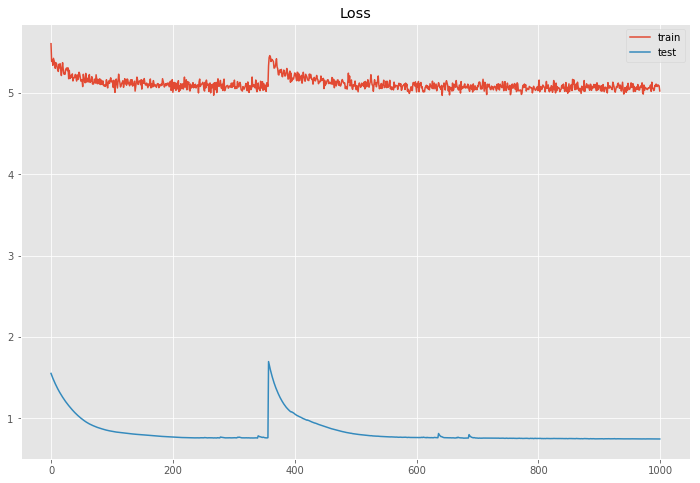

In [47]:
# figure of loss over time

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Loss')
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend();

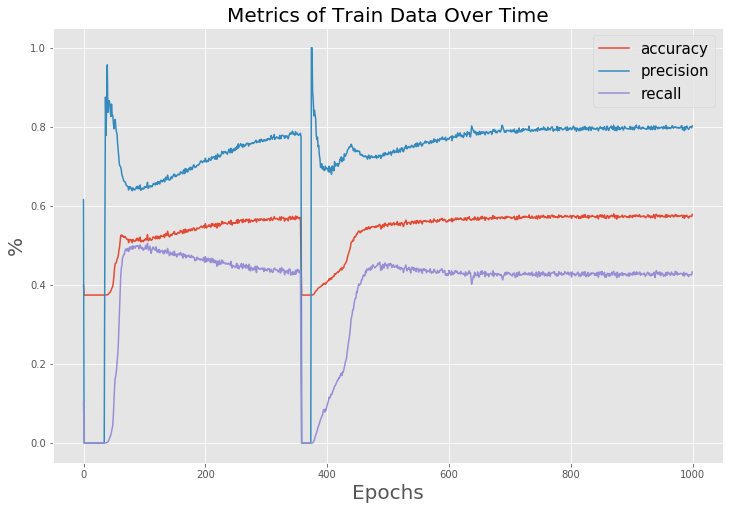

In [49]:
# figure of metrics over time

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Metrics of Train Data Over Time', fontsize=20)
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['precision'], label='precision')
ax.plot(history.history['recall'], label='recall')
ax.set_xlabel('Epochs', fontsize=20)
ax.set_ylabel('%', fontsize=20)
ax.legend(loc='best', fontsize=15);
fig.savefig('../img/metrics_nn.png')

In [50]:
# scale test data and generate predictions

scaler_test = StandardScaler()
X_test = scaler_train.fit_transform(X_test)
y_hat = model.predict(X_test)

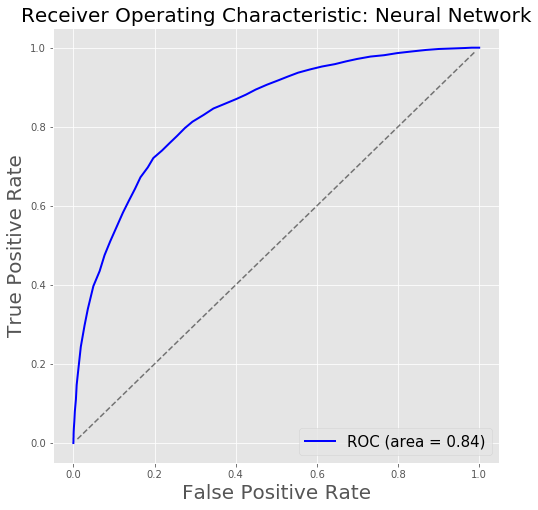

In [51]:
# plot ROC

fig, ax = plt.subplots(figsize=(8,8))

ax, tpr, fpr, thresholds = plot_roc_curve(y_hat, y_test, ax, title='Neural Network')

fig.savefig('../img/roc_nn.png')

In [52]:
# save prediction data to txt for later ROC overlay

np.savetxt('../data/nn_y_hat.txt', y_hat)
np.savetxt('../data/nn_y_test.txt', y_test)

In [55]:
cm_df = confusion_df(y_test, (y_hat > 0.5).astype(int))
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,3805,11
Actual Positive,5710,395


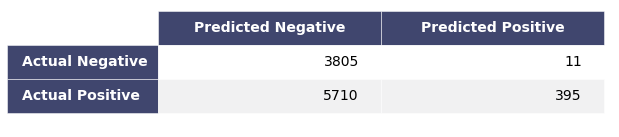

In [74]:
fig, ax = render_mpl_table(cm_df)
fig.show()
fig.savefig('../img/nn_conf_mat.png')